In [68]:
# importing the libraries
import pandas as pd
import numpy as np

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import torch.nn

from torchvision import datasets
import torchvision.transforms as transforms
from torch import nn
import torch.nn.functional as F



In [69]:
train_data = datasets.FashionMNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

valid_data = datasets.FashionMNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

test_data = datasets.FashionMNIST('../data', train=False, download=True,
                      transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

train_idx = np.random.choice(train_data.train_data.shape[0], 54000, replace=False)
train_data.data = train_data.data[train_idx, :]
train_data.targets = train_data.targets[torch.from_numpy(train_idx).type(torch.LongTensor)]

mask = np.ones(60000)
mask[train_idx] = 0

valid_data.data = valid_data.data[torch.from_numpy(np.argwhere(mask)), :].squeeze()
valid_data.targets = valid_data.targets[torch.from_numpy(mask).type(torch.ByteTensor)]

batch_size = 100

train_loader = torch.utils.data.DataLoader(train_data,
    batch_size=batch_size, shuffle=True)

valid_loader = torch.utils.data.DataLoader(valid_data,
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_data,
    batch_size=batch_size, shuffle=True)

C:\w\1\s\tmp_conda_3.7_100118\conda\conda-bld\pytorch_1579082551706\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.


In [70]:
class CnnNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = "cnn"
        self.losses = []
        self.accuracies = []
        
        self.cnn_layers = Sequential(
            Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.linear_layers = Sequential(
            Linear(4 * 7 * 7, 10),
        )
        
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        x = F.log_softmax(x, dim=1)
        return x

In [71]:


class FcNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = "fcnn"
        self.losses = []
        self.accuracies = []
        
        self.linear_layers = Sequential(
            Linear(28*28, 600),
            ReLU(inplace=True),
            Linear(600, 400),
            ReLU(inplace=True),
            Linear(400, 200),
            ReLU(inplace=True),
            Linear(200, 100),
            ReLU(inplace=True),
            Linear(100, 10),
        )

    def forward(self, x):
        x = x.view(x.size()[0], -1)
        x = self.linear_layers(x)
        x = F.log_softmax(x, dim=1)
        return x

In [72]:
class MixNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = "mnn"
        self.losses = []
        self.accuracies = []
        
        self.cnn_layers = Sequential(
            Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            nn.Sigmoid(),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = Sequential(
            Linear(784, 200),
            nn.Sigmoid(),
            Linear(200, 10),
        )
        
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        x = F.log_softmax(x, dim=1)
        return x


In [73]:
lossFct = nn.NLLLoss(reduction='sum')


In [74]:
def train(model, optimizer):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = lossFct(output, target)
        loss.backward()
        optimizer.step()
        

def valid(model):
    valid_loss = 0
    model.eval()
    correct = 0
    for data, target in valid_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        valid_loss += F.nll_loss(output, target, size_average=False).data 
        pred = output.data.max(1, keepdim=True)[1] 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
    print(valid_loss)
    model.losses.append(valid_loss)
    model.accuracies.append(1. * correct / len(valid_loader.dataset))
    
    return valid_loss, 1. * correct / len(valid_loader.dataset)


def test(model):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data
        pred = output.data.max(1, keepdim=True)[1] 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
    print('\n' + model.name + " test" + ' set: Total loss: {:.4f}, Accuracy: {:.0f}%\n'.format(
        test_loss, 100. * correct / len(test_loader.dataset)))
    return test_loss, 1. * correct / len(test_loader.dataset)
        

def fit(model, optimizer, nb_epochs = 50):
    best_model = model
    best_accuracy = 0
    for i in range(nb_epochs):
        train(model, optimizer)
        loss, accuracy = valid(model)
        if accuracy > best_accuracy:
            best_model = model
            best_accuracy = accuracy
    
    test(best_model)

In [75]:
cnn = CnnNet()
cnnOptimizer = SGD(cnn.parameters(), lr=0.001)
fit(cnn, cnnOptimizer)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


tensor(2590.3020)
tensor(2216.6060)
tensor(2168.9893)
tensor(2076.7932)
tensor(1986.5901)
tensor(2023.7062)
tensor(2022.0291)
tensor(1994.7456)
tensor(1915.0286)
tensor(2090.3804)
tensor(2078.4434)
tensor(1844.3778)
tensor(1853.5616)
tensor(1859.0691)
tensor(2079.9319)
tensor(1850.7119)
tensor(1943.2062)
tensor(1845.6322)
tensor(1821.3553)
tensor(1796.2758)

cnn test set: Total loss: 3241.9197, Accuracy: 88%



In [76]:
fcnn = FcNet()
fcOptimizer = Adam(fcnn.parameters(), lr=0.001)
fit(fcnn, fcOptimizer)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


tensor(2312.5027)
tensor(2123.9680)
tensor(1976.9635)
tensor(1766.0015)
tensor(1882.8093)
tensor(1896.6799)
tensor(1864.4623)
tensor(1713.4581)
tensor(1714.3269)
tensor(1719.1224)
tensor(1781.0747)
tensor(2038.2939)
tensor(1838.5919)
tensor(2105.7532)
tensor(2217.7957)
tensor(2024.1014)
tensor(2075.0386)
tensor(2218.8887)
tensor(2133.8188)
tensor(2162.3970)

fcnn test set: Total loss: 4124.0386, Accuracy: 89%



In [77]:
mnn = MixNet()
mnnOptimizer = Adam(mnn.parameters(), lr=0.002)
fit(mnn, mnnOptimizer)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


tensor(2591.3315)
tensor(2235.5645)
tensor(1991.9076)
tensor(1847.3517)
tensor(1785.3344)
tensor(1768.5303)
tensor(1648.7893)
tensor(1628.3033)
tensor(1575.9969)
tensor(1637.3394)
tensor(1723.0597)
tensor(1523.0409)
tensor(1492.7173)
tensor(1464.1432)
tensor(1469.9174)
tensor(1542.6018)
tensor(1520.6852)
tensor(1526.3607)
tensor(1524.2764)
tensor(1525.0245)

mnn test set: Total loss: 2701.4976, Accuracy: 91%



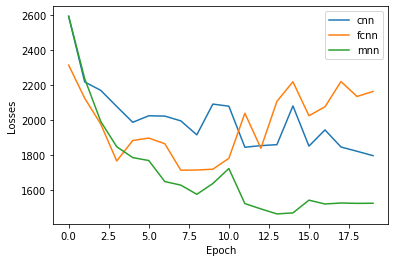

In [78]:
plt.plot(cnn.losses, label=cnn.name)
plt.plot(fcnn.losses, label=fcnn.name)
plt.plot(mnn.losses, label=mnn.name)
plt.ylabel("Losses")
plt.xlabel("Epoch")
plt.legend()
plt.show()

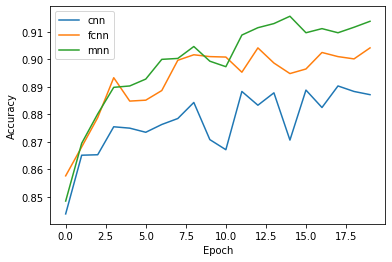

In [79]:
plt.plot(cnn.accuracies, label=cnn.name)
plt.plot(fcnn.accuracies, label=fcnn.name)
plt.plot(mnn.accuracies, label=mnn.name)
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

